In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

import PIL
import PIL.Image as Image

import matplotlib.pyplot as plt

import numpy as np

import datetime

# import cv2

import os

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Tensorboard overview can be found at the end of the file

In [76]:
# # Clear any logs from previous runs
# rm -rf notebooks/logs/

In [77]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [78]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 383 files belonging to 4 classes.


In [79]:
class_names = dataset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [80]:
# len(dataset)

In [81]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/Test",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 120 files belonging to 4 classes.


In [82]:
class_names = testset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [83]:
# len(testset)

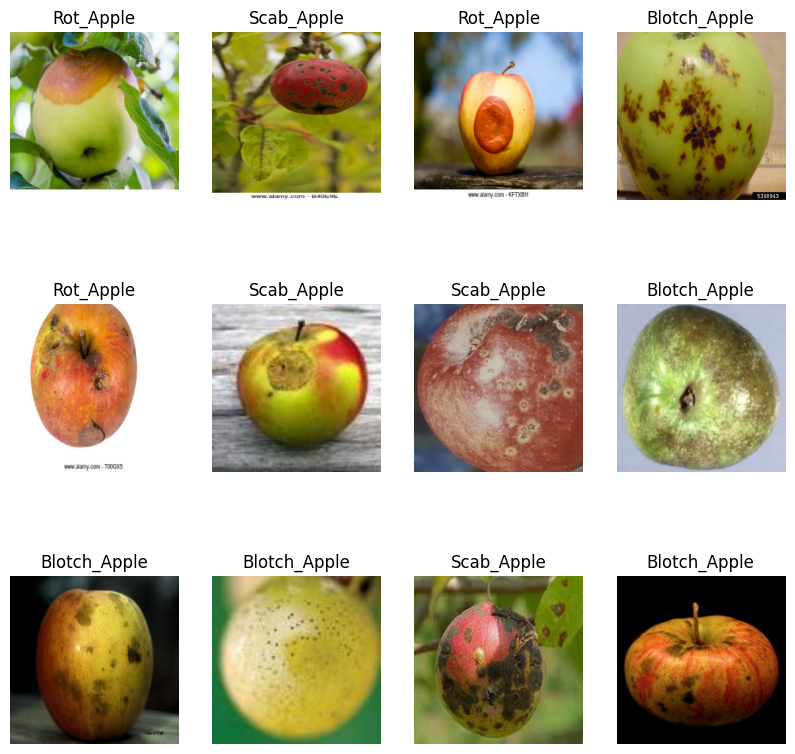

In [84]:
plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in dataset.take(1): # toont at random afbeeldingen uit de dataset
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print(image_batch[0].numpy)
    # print(image_batch[0].shape)
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        # plt.imshow(image_batch[0].numpy().astype("uint8"))
        # plt.title(class_names[label_batch[0]])
        plt.imshow(image_batch[i].numpy().astype("uint8")) # met [i] ipv [0] wordt de loop doorlopen en 12 afb. getoond
        plt.title(class_names[label_batch[i]])
        plt.axis("off") # om extra informatie (> assen) uit te zetten

In [85]:
# plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
# for image_batch, label_batch in testset.take(1): # toont at random afbeeldingen uit de dataset
#     for i in range(12):
#         ax = plt.subplot(3, 4, i+1)    
#         plt.imshow(image_batch[i].numpy().astype("uint8")) 
#         plt.title(class_names[label_batch[i]])
#         plt.axis("off") 

In [86]:
train_size = 0.8
len(dataset)*train_size

9.600000000000001

In [87]:
train_ds = dataset.take(9) # met .take() worden de eerste (x) batches geslecteerd
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [88]:
# test_ds = dataset.skip() # met .skip() worden er overgeslagen
# omdat we een aparte folder voor de test-dataset hebben, kunnen we deze als onderstaand inladen
test_ds = testset
len(test_ds) # lengte in batches
type(test_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [89]:
val_size = 0.2
len(dataset)*val_size

2.4000000000000004

In [90]:
val_ds = dataset.skip(9)
len(val_ds)

3

In [91]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):

    assert (train_split + val_split) == 1 # test_split niet want extra folder

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size) # als we de test-dataset ook uit dezelfde batch/folder zouden halen
    test_ds = testset
        
    return train_ds, val_ds, test_ds

In [92]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [93]:
# len(train_ds)
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [94]:
# len(val_ds)

In [95]:
# len(test_ds)

In [96]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) ## bij CPU én GPU gebruik.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [97]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)    
])

In [98]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Apply data augmentation to train dataset

In [99]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [100]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

In [101]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 4

# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
#     # tf.keras.layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),   
#     layers.Dropout(0.2), 
#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(258, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),    
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')          
# ])

# model.build(input_shape=input_shape)

In [102]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [103]:
# model.summary()

In [104]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [105]:
# model.compile(
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

In [106]:
# history = model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=val_ds,
#     callbacks = [tensorboard_callback]
# )

In [107]:
# scores = model.evaluate(test_ds)

In [108]:
# scores

In [109]:
# history

In [110]:
# history.params

In [111]:
# history.history.keys()

In [112]:
# len(history.history['accuracy'])

In [113]:
# type(history.history['loss'])
# len(history.history['loss'])

In [114]:
# history.history['loss'][:5]# show loss for first 5 epochs

In [115]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

In [116]:
# plt.figure(figsize=(16, 8))

# plt.subplot(1, 2, 1)
# plt.plot(range(EPOCHS), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')

# plt.show()

In [117]:
# for images_batch, labels_batch in test_ds.take(1):
    
#     first_image = images_batch[0].numpy().astype('uint8')
#     first_label = labels_batch[0].numpy()
    
#     print("First image to predict")
#     plt.imshow(first_image)
#     plt.axis("off")
#     print("First image's actual label:", class_names[first_label])
    
#     batch_prediction = model.predict(images_batch)
#     print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    # print(batch_prediction[0]) # input for np.argmax() above
    

In [118]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
#     img_array = tf.expand_dims(img_array, 0) # Create a batch
    
#     predictions = model.predict(img_array)
       
#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence
                                  

In [119]:
# plt.figure(figsize=(15, 15))
# for images, labels in test_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i+1)
        
#         plt.imshow(images[i].numpy().astype("uint8"))
        
#         predicted_class, confidence = predict(model, images[i].numpy()) 
#         actual_class = class_names[labels[i]]
        
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
#         plt.axis("off")

Invloed van watermerken op de afbeeldingen? Normal Apple met watermerkje wordt vaak als Blotch Apple aangemerkt.

To save the model autmatically we can use the follow code. Each time we run the model a new folder will be created.

In [120]:
#import os - add to top

# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}") # Checked the ValueError: invalid literal for int() with base 10: '.gitkeep' <<< Removed placeholder .gitkeep to get this working. .gitkeep is only used to push empty folders.

There are two formats you can use to save an entire model to disk: the <strong>TensorFlow SavedModel </strong>format, and the older Keras H5 format. The recommended format is SavedModel. It is the default when you use model.save(). > https://www.tensorflow.org/guide/keras/ save_and_serialize <. Hence the method above is preferred.

In [121]:
# model.save("..models/../apples.h5")

Ergo, above is depricated

In [122]:
# model.predict(test_ds)

In [123]:
# predictionBatch = model.predict(test_ds)
# predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
# actualCategories = tf.concat([y for x, y in test_ds], axis=0)

# confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

# cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

# cmDisplay.plot()

# plt.show()

In [124]:
# %tensorboard --logdir logs/fitb

<h3><strong>Transfer Learning</strong></h3>

In [125]:
# rm -rf notebooks/logs/

Now take pre-trained model and retrain it using apple images

In [126]:
# feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# pretrained_model_without_top_layer = hub.KerasLayer(
#     feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

Resize the images

In [127]:
# size = (224, 224)

# train_ds_tl = train_ds.map(lambda x, y : (tf.image.resize (x, size), y))
# val_ds_tl = val_ds.map(lambda x, y : (tf.image.resize (x, size), y))
# test_ds_tl = test_ds.map(lambda x, y : (tf.image.resize (x, size), y))

In [128]:
# num_of_apples = 4

# model = tf.keras.Sequential([
#   pretrained_model_without_top_layer,
#   tf.keras.layers.Dense(num_of_apples)
# ])

# model.summary()

In [129]:
# model.compile(
#   optimizer="adam",
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

# model.fit(train_ds_tl, validation_data=val_ds_tl, epochs=10)

In [130]:
# scores_tl = model.evaluate(test_ds_tl)

In [131]:
# model.predict(test_ds_tl)

In [132]:
# predictionBatch = model.predict(test_ds_tl)
# predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
# actualCategories = tf.concat([y for x, y in test_ds], axis=0)

# confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

# cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

# cmDisplay.plot()

# plt.show()

<h3><strong>Transfer Learning v2</strong><h3>

In [133]:
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# train_path = "C:/MakeAIWork2/projects/apple_disease_classification/data/Train"
# valid_path = "C:/MakeAIWork2/projects/apple_disease_classification/data/Test"

# train_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(train_path, target_size = (224, 224), batch_size = 30)
# valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(valid_path, target_size = (224, 224), batch_size = 20)

# train_generator = test_ds
# valid_generator = val_ds

# https://www.youtube.com/watch?v=DElZ6sn3ADI&t=656s

In [134]:
size = (224, 224)

train_ds_tl = train_ds.map(lambda x, y : (tf.image.resize (x, size), y))
val_ds_tl = val_ds.map(lambda x, y : (tf.image.resize (x, size), y))
test_ds_tl = test_ds.map(lambda x, y : (tf.image.resize (x, size), y))

<h3><strong>Build the model</strong></h3>

Load the pretrained model and add a Dense layer to adjust to our classification of the apples

In [135]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

#load pretrained weights and remove last layer, which will be replaced by below:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(4, activation='softmax') (x)

# last lays should correspond to number of classes: 4

model=Model(inputs=base_model.input, outputs=preds)

Pretrained layers need to frozen

In [136]:
# check the model so far
model.summary()

# Trainable parameters: 3,044,484 (non-trainable: 34,112)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [137]:
for layers in model.layers[:-5]:
    layers.trainable = False

In [138]:
# check the 'new 'model' with frozen layers
model.summary()

# Result is a lot less trainable parameters: 820,612 (+ non-trainable: 2,257,984)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

Compile and fit the model

In [139]:
EPOCHS = 20
optimizer = Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(train_ds_tl, validation_data=val_ds_tl, epochs=EPOCHS)

Epoch 1/20
9/9 [==============================] - 6s 448ms/step - loss: 1.3319 - accuracy: 0.4286 - val_loss: 1.1000 - val_accuracy: 0.5312
Epoch 2/20
9/9 [==============================] - 3s 310ms/step - loss: 1.0236 - accuracy: 0.5784 - val_loss: 1.0129 - val_accuracy: 0.5781
Epoch 3/20
9/9 [==============================] - 3s 311ms/step - loss: 0.9244 - accuracy: 0.6167 - val_loss: 0.9659 - val_accuracy: 0.5938
Epoch 4/20
9/9 [==============================] - 3s 303ms/step - loss: 0.8727 - accuracy: 0.6272 - val_loss: 0.7693 - val_accuracy: 0.7031
Epoch 5/20
9/9 [==============================] - 3s 309ms/step - loss: 0.7207 - accuracy: 0.7108 - val_loss: 0.8118 - val_accuracy: 0.6562
Epoch 6/20
9/9 [==============================] - 3s 314ms/step - loss: 0.7416 - accuracy: 0.7108 - val_loss: 0.7162 - val_accuracy: 0.6875
Epoch 7/20
9/9 [==============================] - 3s 306ms/step - loss: 0.7385 - accuracy: 0.6899 - val_loss: 0.7583 - val_accuracy: 0.6406
Epoch 8/20
9/9 [====

In [140]:
scores_tl2 = model.evaluate(test_ds_tl)

4/4 [==============================] - 0s 71ms/step - loss: 1.2398 - accuracy: 0.5167


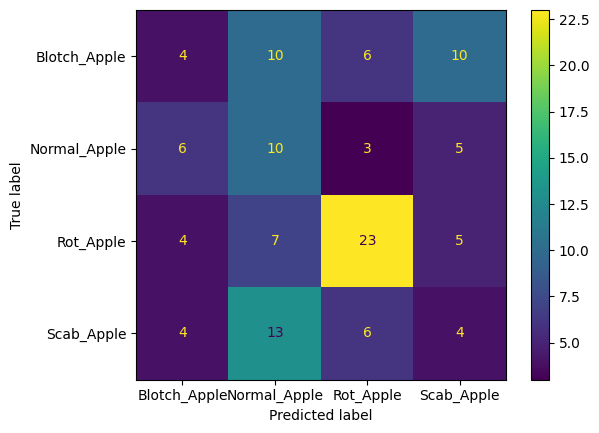

In [141]:
predictionBatch = model.predict(test_ds_tl)
predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
actualCategories = tf.concat([y for x, y in test_ds], axis=0)

confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cmDisplay.plot()

plt.show()

First image to predict
First image's actual label: Rot_Apple
Predicted label: Rot_Apple
[2.3601580e-05 4.1504752e-02 9.5841908e-01 5.2606854e-05]


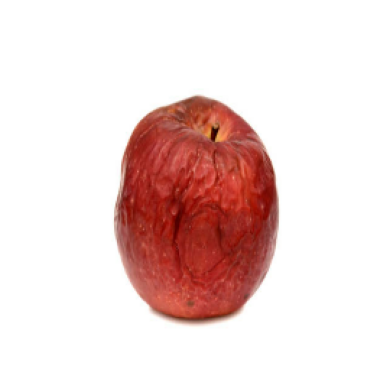

In [142]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    print(batch_prediction[0]) # input for np.argmax() above

In [143]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
       
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

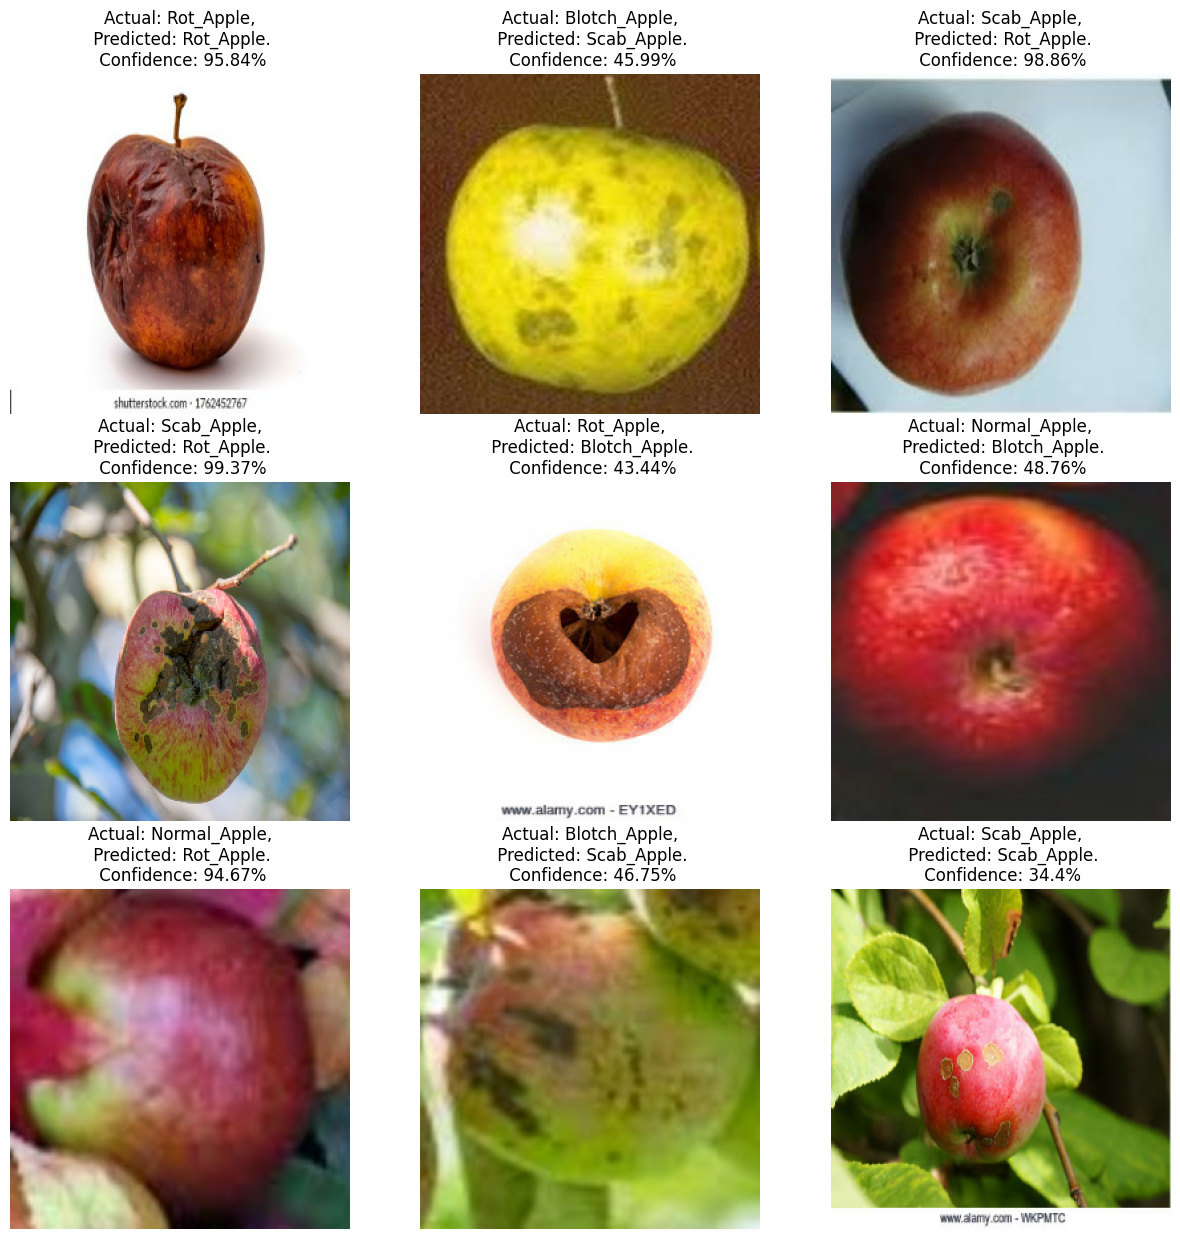

In [144]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")